In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import requests
import pickle

In [2]:
df = pd.read_csv('./city_temperature.csv')
df.describe()

C:\Users\merci\AppData\Local\Temp\ipykernel_24652\926518620.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./city_temperature.csv')


,Month,Day,Year,AvgTemperature
count,2.906327e+06,2.906327e+06,2.906327e+06,2.906327e+06
mean,6.469163e+00,1.571682e+01,2.006624e+03,5.600492e+01
std,3.456489e+00,8.800534e+00,2.338226e+01,3.212359e+01
min,1.000000e+00,0.000000e+00,2.000000e+02,-9.900000e+01
25%,3.000000e+00,8.000000e+00,2.001000e+03,4.580000e+01
50%,6.000000e+00,1.600000e+01,2.007000e+03,6.250000e+01
75%,9.000000e+00,2.300000e+01,2.013000e+03,7.550000e+01
max,1.200000e+01,3.100000e+01,2.020000e+03,1.100000e+02


In [3]:
df.columns

Index(['Region', 'Country', 'State', 'City', 'Month', 'Day', 'Year',
       'AvgTemperature'],
      dtype='object')

In [4]:
df[df["City"] == 'Paris'].groupby('Year').describe()

Month                                                    Day             \
      count      mean       std  min  25%  50%    75%   max  count       mean   
Year                                                                            
1995  365.0  6.526027  3.452584  1.0  4.0  7.0  10.00  12.0  365.0  15.720548   
1996  366.0  6.513661  3.455958  1.0  4.0  7.0   9.75  12.0  366.0  15.756831   
1997  365.0  6.526027  3.452584  1.0  4.0  7.0  10.00  12.0  365.0  15.720548   
1998  365.0  6.526027  3.452584  1.0  4.0  7.0  10.00  12.0  365.0  15.720548   
1999  365.0  6.526027  3.452584  1.0  4.0  7.0  10.00  12.0  365.0  15.720548   
2000  366.0  6.513661  3.455958  1.0  4.0  7.0   9.75  12.0  366.0  15.756831   
2001  365.0  6.526027  3.452584  1.0  4.0  7.0  10.00  12.0  365.0  15.720548   
2002  365.0  6.526027  3.452584  1.0  4.0  7.0  10.00  12.0  365.0  15.720548   
2003  365.0  6.526027  3.452584  1.0  4.0  7.0  10.00  12.0  365.0  15.720548   
2004  366.0  6.513661  3.455958  1.0  4.0  7.0   9.75  12.0  366.0  15.756831   
2005  365.0  6.526027  3.452584  1.0  4.0  7.0  10.00  12.0  365.0  15.720548   
2006  365.0  6.526027  3.452584  1.0  4.0  7.0  10.00  12.0  365.0  15.720548   
2007  365.0  6.526027  3.452584  1.0  4.0  7.0  10.00  12.0  365.0  15.720548   
2008  366.0  6.513661  3.455958  1.0  4.0  7.0   9.75  12.0  366.0  15.756831   
2009  365.0  6.526027  3.452584  1.0  4.0  7.0  10.00  12.0  365.0  15.720548   
2010  365.0  6.526027  3.452584  1.0  4.0  7.0  10.00  12.0  365.0  15.720548   
2011  365.0  6.526027  3.452584  1.0  4.0  7.0  10.00  12.0  365.0  15.720548   
2012  366.0  6.513661  3.455958  1.0  4.0  7.0   9.75  12.0  366.0  15.756831   
2013  365.0  6.526027  3.452584  1.0  4.0  7.0  10.00  12.0  365.0  15.720548   
2014  365.0  6.526027  3.452584  1.0  4.0  7.0  10.00  12.0  365.0  15.720548   
2015  366.0  6.540984  3.459704  1.0  4.0  7.0  10.00  12.0  366.0  15.759563   
2016  366.0  6.513661  3.455958  1.0  4.0  7.0   9.75  12.0  366.0  15.756831   
2017  365.0  6.526027  3.452584  1.0  4.0  7.0  10.00  12.0  365.0  15.720548   
2018  365.0  6.526027  3.452584  1.0  4.0  7.0  10.00  12.0  365.0  15.720548   
2019  365.0  6.526027  3.452584  1.0  4.0  7.0  10.00  12.0  365.0  15.720548   
2020  134.0  2.738806  1.303143  1.0  2.0  3.0   4.00   5.0  134.0  14.798507   

      ...             AvgTemperature                                      \
      ...   75%   max          count       mean        std   min     25%   
Year  ...                                                                  
1995  ...  23.0  31.0          365.0  53.742192  20.406326 -99.0  45.800   
1996  ...  23.0  31.0          366.0  52.293169  15.207325 -99.0  42.450   
1997  ...  23.0  31.0          365.0  55.580000  12.745185  13.8  47.700   
1998  ...  23.0  31.0          365.0  50.317534  27.794295 -99.0  46.000   
1999  ...  23.0  31.0          365.0  54.565753  13.990209 -99.0  46.400   
2000  ...  23.0  31.0          366.0  54.337705  10.345685  28.3  46.625   
2001  ...  23.0  31.0          365.0  53.944932  12.074808  28.3  44.800   
2002  ...  23.0  31.0          365.0  52.743014  18.722075 -99.0  47.600   
2003  ...  23.0  31.0          365.0  54.562192  13.721165  20.1  44.200   
2004  ...  23.0  31.0          366.0  53.585246  11.761756  28.1  43.650   
2005  ...  23.0  31.0          365.0  53.407671  14.983372 -99.0  43.700   
2006  ...  23.0  31.0          365.0  54.199726  13.030266  25.3  42.600   
2007  ...  23.0  31.0          365.0  53.572055  12.962494 -99.0  47.100   
2008  ...  23.0  31.0          366.0  52.381694  15.655254 -99.0  44.925   
2009  ...  23.0  31.0          365.0  53.061096  14.640168 -99.0  44.600   
2010  ...  23.0  31.0          365.0  51.648219  13.601742  22.9  40.600   
2011  ...  23.0  31.0          365.0  55.001918  10.339226  25.7  47.200   
2012  ...  23.0  31.0          366.0  53.256557  11.453752  20.7  46.500   
2013  ...  23.0  31.0          365.0  52.088493  14.922241 -

### Data cleaning

In [5]:
# Traitement des années
df.drop(df.Year[df.Year < 1995].index, inplace=True)
df.drop(df.Year[df.Year > 2019].index, inplace=True)
df.Year.unique()

array([1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019], dtype=int64)

In [6]:
# Traitement des jours
df.drop(df.Day[df.Day == 0].index, inplace=True)
df.Day.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
      dtype=int64)

In [7]:
# Traitement des températures
df.drop(df[df.AvgTemperature == -99.0].index, inplace=True)
df[df.AvgTemperature > 100]

,Region,Country,State,City,Month,Day,Year,AvgTemperature
50515,Africa,Egypt,NaN,Cairo,5,23,2019,100.2
88434,Africa,Guinea-Bissau,NaN,Bissau,4,16,1998,100.1
166361,Africa,Nigeria,NaN,Niamey,4,18,1998,102.8
166367,Africa,Nigeria,NaN,Niamey,4,24,1998,101.4
167122,Africa,Nigeria,NaN,Niamey,5,18,2000,101.8
...,...,...,...,...,...,...,...,...
2235317,North America,US,Nevada,Las Vegas,7,28,2018,102.7
2235321,North America,US,Nevada,Las Vegas,8,1,2018,100.1
2235668,North America,US,Nevada,Las Vegas,7,14,2019,100.3
2235683,North America,US,Nevada,Las Vegas,7,29,2019,100.6


In [8]:
df['AvgTemperature'] = df['AvgTemperature'].map(lambda x: (x - 32) * (5/9))

In [9]:
# Nettoyage des noms des villes
dict_correction_city = {'Montvideo' : 'Montevideo', 
                        'Hartford Springfield' : 'Hartford', 
                        'Tampa St. Petersburg' : 'Tampa', 
                        'Minneapolis St. Paul' : 'Minneapolis', 
                        'Raleigh Durham' : 'Durham', 
                        'Akron Canton' : 'Akron', 
                        'Dallas Ft Worth' : 'Dallas', 
                        'Midland Odessa' : 'Midland', 
                        'San Juan Puerto Rico' : 'San Juan'
}

for key, value in dict_correction_city.items():
    df['City'] = df['City'].map(lambda x: value if x == key else x)

#### Requête API

In [10]:
def request_APICITY(city):
    api_url = 'https://api.api-ninjas.com/v1/geocoding?city={}'.format(city)
    response = requests.get(api_url, headers={'X-Api-Key': '8TrYo5jsiYgj3ZsTp2E4zQ==E1uuPAfF2D5wRXXH'})
    if response.status_code == requests.codes.ok:
        res = response.json()
        if len(res) > 0:
            return res[0]
    else:
        print("Error:", response.status_code, response.text)
    return None


In [11]:
# list_city = df['City'].unique()
# dict_city = {}
# list_city_error = []

# for city in list_city:
#     return_api = request_APICITY(city)
#     if return_api is not None:   
#         dict_city[city] = {'lat': return_api['latitude'], 'lon': return_api['longitude']}
#     else:
#         list_city_error.append(city)

# print(dict_city)
# print(list_city_error)

In [12]:
# with open('dict_city.pickle', 'wb') as handle:
#     pickle.dump(dict_city, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
# read pickle
with open('dict_city.pickle', 'rb') as handle:
    dict_city = pickle.load(handle)

### Courbe Temperature

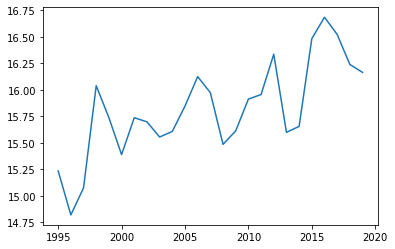

In [13]:
plt.plot(df.groupby('Year').mean()['AvgTemperature'])
plt.show()


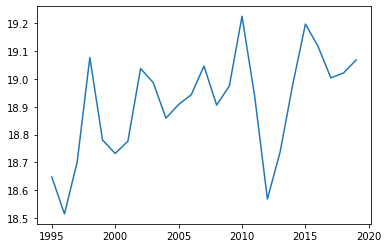

In [14]:
# Group by country then by year
# I want to know the average temperature of each country for each yea
plt.plot(df.groupby(['Country', 'Year']).mean().groupby('Year').mean()['AvgTemperature'])
plt.show()

In [19]:
# df['date'] = df.apply(lambda row: datetime(row.Year, row.Month, row.Day), axis=1)

In [21]:
# export to csv
# df.to_csv('cleaned_city_temperature.csv', index=False)

In [22]:
df = pd.read_csv('./cleaned_city_temperature.csv', parse_dates=['date'])

C:\Users\merci\AppData\Local\Temp\ipykernel_24652\3008910514.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./cleaned_city_temperature.csv', parse_dates=['date'])


In [23]:
tt = df.groupby(['Country','date']).mean()

In [24]:
tt.reset_index(inplace=True)

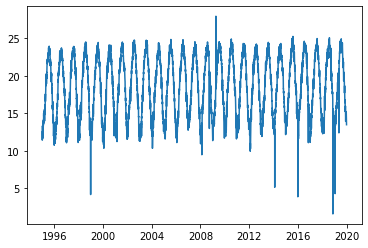

In [25]:
plt.plot(tt.groupby('date').mean()['AvgTemperature'])

C:\Users\merci\AppData\Local\Temp\ipykernel_24652\2635534453.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tt[tt.Country == 'France'][tt.Year == 2019.0].plot.scatter(x='date', y='AvgTemperature', c='DarkBlue')


<AxesSubplot:xlabel='date', ylabel='AvgTemperature'>

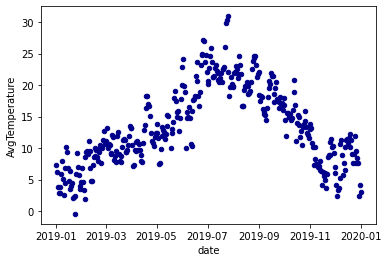

In [26]:
tt[tt.Country == 'France'][tt.Year == 2019.0].plot.scatter(x='date', y='AvgTemperature', c='DarkBlue')

C:\Users\merci\AppData\Local\Temp\ipykernel_24652\2992122178.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tt[tt.Country == 'Argentina'][tt.Year == 2019.0].plot.scatter(x='date', y='AvgTemperature', c='DarkBlue')


<AxesSubplot:xlabel='date', ylabel='AvgTemperature'>

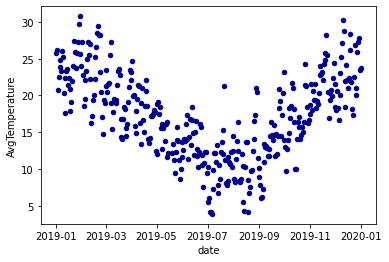

In [27]:
tt[tt.Country == 'Argentina'][tt.Year == 2019.0].plot.scatter(x='date', y='AvgTemperature', c='DarkBlue')


C:\Users\merci\AppData\Local\Temp\ipykernel_24652\1304170453.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tt[tt.Country == 'Equador'][tt.Year == 2019.0].plot.scatter(x='date', y='AvgTemperature', c='DarkBlue')


<AxesSubplot:xlabel='date', ylabel='AvgTemperature'>

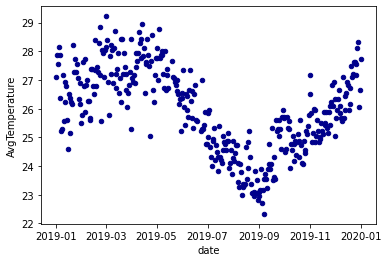

In [28]:
tt[tt.Country == 'Equador'][tt.Year == 2019.0].plot.scatter(x='date', y='AvgTemperature', c='DarkBlue')

C:\Users\merci\AppData\Local\Temp\ipykernel_24652\3645296859.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tt[tt.Country == 'Singapore'][tt.Year == 2019.0].plot.scatter(x='date', y='AvgTemperature', c='DarkBlue')


<AxesSubplot:xlabel='date', ylabel='AvgTemperature'>

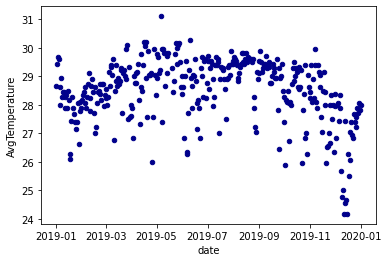

In [29]:
tt[tt.Country == 'Singapore'][tt.Year == 2019.0].plot.scatter(x='date', y='AvgTemperature', c='DarkBlue')

In [ ]:
# NMF